In [ ]:
# Team Leopard

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
seed=1234

In [3]:
# read the data from txt, tab separeted
df= pd.read_table('datasets-v3_1/task-1/task1.train.txt', header= None)

In [4]:
df.columns = ['text', 'id', 'label']
df.set_index('id', inplace= True)

In [5]:
df[:3]

,text,label
id,,
727600136,"Et tu, Rhody? A recent editorial in the Provi...",non-propaganda
731714618,A recent post in The Farmington Mirror — our t...,non-propaganda
731714635,"President Donald Trump, as he often does while...",non-propaganda


## Text Analysis

Text(0.5, 0, 'n of articles')

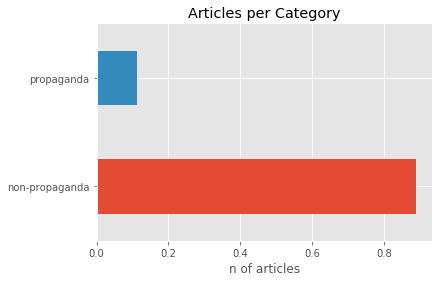

In [6]:
df['label'].value_counts(normalize= True).plot(kind='barh')
plt.title('Articles per Category')
plt.xlabel('n of articles')

In [7]:
# mapping 1 propaganda, 0 non propaganda
MAP= {'propaganda':1, 'non-propaganda':0}
df['cat']= df['label'].map(MAP)

In [8]:
def plot_n_len(ser):
    '''Given a Series containing text, isualize words number and count distribution per article.
    return total number of words'''
    results = set()
    ser.str.lower().str.split().apply(results.update)
    print(f'Total number of words: {len(results)}')
    l_art = ser.apply(lambda words: len(words.split(" ")))
    plt.figure(figsize=(8, 5))
    sns.boxplot(x= l_art, orient= 'h',)
    plt.title('Number of Words per Article')
    return len(results)

Total number of words: 562249


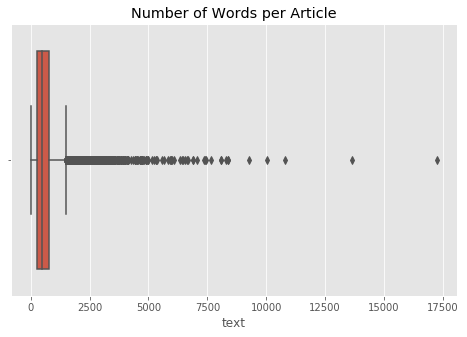

In [9]:
n_words1= plot_n_len(df['text'])

## Text Analysis -  Cleaning

In [15]:
# mappinf of contractions
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [2]:
# clean the text
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def text_cleaner(text):
    '''Given a text Serie, return the Serie cleaned ( space separated, low, special/digits removed)'''
    text = re.sub("„", " ", text)    
    text = re.sub(r'[0-9]+', ' ', text)
    text = re.sub(r'[\n\t]', ' ', text)
    text = re.sub(r"'s", '', text)
    text = re.sub("’", "'", text)
    expanded = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])
    tokens = nlp(expanded, disable=['parser', 'ner'])
    tokens = [t.lemma_.lower().strip() for t in tokens if t.lemma_ != '-PRON-']
    tokens = [t for t in tokens if t not in STOP_WORDS 
              and t not in punctuations and t.isdigit() == False and len(t)>2]
    tokens = ' '.join(tokens)

    return tokens

In [271]:
%timeit df['text'].iloc[:10].apply(text_cleaner)

1.24 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [272]:
df['text'].iloc[:10].apply(text_cleaner)

id
727600136    rhody recent editorial providence journal cata...
731714618    recent post farmington mirror town version oni...
731714635    president donald trump respond natural disaste...
728627182    february black history month loom large black ...
728627443    snow heavy whip gust wind travel nearly imposs...
732126660    month sandy hook school shooting connecticut l...
728144791    major newspaper article donald trump describe ...
728605281    year start new york art dealer robert simon si...
731383701    president donald trump tumultuous administrati...
734075146    hartford edge future aetna cvs health corp. ch...
Name: text, dtype: object

In [30]:
# to be reactivated if needed
import pickle
'''
df['text_clean']= df['text'].apply(text_cleaner)
#dump to picle
df.to_pickle('cleaned.pkl')
'''

In [10]:
df= pd.read_pickle('cleaned.pkl')

In [11]:
df[:3]

,text,label,cat,text_clean
id,,,,
727600136,"Et tu, Rhody? A recent editorial in the Provi...",non-propaganda,0,rhody recent editorial providence journal cata...
731714618,A recent post in The Farmington Mirror — our t...,non-propaganda,0,recent post farmington mirror town version oni...
731714635,"President Donald Trump, as he often does while...",non-propaganda,0,president donald trump respond natural disaste...


Total number of words: 172312


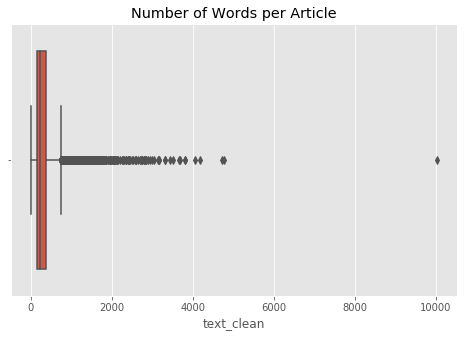

In [12]:
# Visualize words count distribution

n_word_cleaned= plot_n_len(df['text_clean'])

In [13]:
print('Uncleaned-cleaned text n of words difference', 
      round(((n_word_cleaned - n_words1) / n_words1), 2) *100, '%')

Uncleaned-cleaned text n of words difference -69.0 %


In [14]:
# shuffle so not 1 and 0 are mixed
df= shuffle(df)
df[:5]

,text,label,cat,text_clean
id,,,,
753990045,"An alligator seen in Avondale, La., on April 2...",non-propaganda,0,alligator avondale louisiana april tyler kaufm...
755575725,Secretary of State Mike Pompeo says that North...,non-propaganda,0,secretary state mike pompeo north korea receiv...
755323202,LIMA: Vice President M Venkaiah Naidu has held...,non-propaganda,0,lima vice president venkaiah naidu hold extens...
729567741,Rob Porter with White House press secretary Sa...,non-propaganda,0,rob porter white house press secretary sarah h...
755044379,MOSCOW (Sputnik) - The Russian Defense Ministr...,non-propaganda,0,moscow sputnik russian defense ministry seismi...


In [15]:
from sklearn.model_selection import train_test_split
# splitting the data in test and train
X_train, X_test, y_train, y_test= train_test_split(df['text_clean'], df['cat'],
                                                   test_size= 0.25, random_state= 1234)

In [101]:
X_vtrain= tvec.fit_transform(X_train)
X_vtest= tvec.transform(X_test)

## Data Exploration using Logistic Regression

Selecting the best 

In [16]:
max_features= int(1e6)

In [17]:
tvec= TfidfVectorizer(min_df=5, max_df= 0.9, lowercase= False, max_features= max_features)
lr=  LogisticRegression(class_weight= 'balanced', solver= 'lbfgs')

In [111]:
lr_param= dict(tvec__ngram_range= [(1,1), (1,2), (1,3)])

In [112]:
lr_clf= Pipeline([('tvec', tvec), ('clf', lr)])

In [113]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
lr_random= GridSearchCV(lr_clf, lr_param, scoring='f1', n_jobs = -1, cv= 3)

In [114]:
lr_random.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.9, max_features=1000000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=Tr...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [115]:
print('Best score:', round(lr_random.best_score_,3), 'with', lr_random.best_params_)

Best score: 0.781 with {'tvec__ngram_range': (1, 3)}


## test different calssifiers

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2

In [109]:
classifiers = [
    ('LogisticRegression', LogisticRegression()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('Kneighbors', KNeighborsClassifier(2)),
    ('MLP', MLPClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('GradientBoosting', GradientBoostingClassifier())]
results=[]

for c in classifiers: 
    clf= Pipeline([('sel', SelectKBest(chi2, k=500)),
                   ('clf', c[1])])
    print(f'Fitting {c[0]} classifier...')
    clf.fit(X_vtrain, y_train)
    print('Predicting...')
    y_pred= clf.predict(X_vtest)
    results.append((c[0], f1_score(y_test, y_pred), y_pred))

Fitting LogisticRegression classifier...


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Predicting...
Fitting DecisionTree classifier...
Predicting...
Fitting RandomForest classifier...


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicting...
Fitting Kneighbors classifier...
Predicting...
Fitting MLP classifier...


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Predicting...
Fitting AdaBoost classifier...
Predicting...
Fitting GradientBoosting classifier...
Predicting...


Text(0.5, 0, 'f1 score')

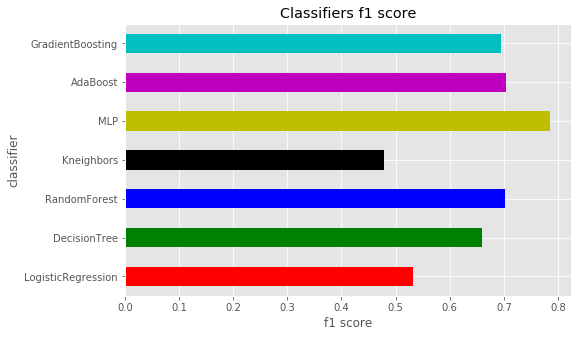

In [116]:
results= pd.DataFrame(results, columns=['classifier', 'f1_score', 'results'])
results[['classifier', 'f1_score']].set_index('classifier').plot(kind='barh',
                                                                 color= 'rgbkymc', legend=None, figsize=(8,5))
plt.title('Classifiers f1 score')
plt.xlabel('f1 score')

In [117]:
results[['classifier', 'f1_score']]

,classifier,f1_score
0,LogisticRegression,0.532656
1,DecisionTree,0.659386
2,RandomForest,0.701643
3,Kneighbors,0.477658
4,MLP,0.785026
5,AdaBoost,0.703990
6,GradientBoosting,0.695369


## Logistic regression tuning

In [83]:
tvec= TfidfVectorizer(max_df= 0.9, min_df=5, lowercase= False, ngram_range= (1,3), max_features= max_features)
lr=  LogisticRegression(solver= 'lbfgs', class_weight= 'balanced')

In [84]:
lr_param_grid = dict(
    C= [10, 100, 1e3, 1e4],
    max_iter= [100, 200, 300]
    )

In [87]:
lr_random_search= RandomizedSearchCV(lr, param_distributions= lr_param_grid,
                                    scoring= 'f1', n_iter=8, n_jobs=-1, cv=3)

In [88]:
lr_random_search.fit(X_vtrain, y_train)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=8, n_jobs=-1,
          param_distributions={'C': [10, 100, 1000.0, 10000.0], 'max_iter': [100, 200, 300]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [89]:
y_pred= lr_random_search.predict(X_vtest)

In [90]:
lr_random_search.best_params_

{'max_iter': 100, 'C': 1000.0}

In [91]:
f1_score(y_test, y_pred)

0.8371089536138079

# MLP tuning

In [127]:
mlp_k_f1score= {}
for k in np.arange(50, 1000, 100):
    mlp_pip= Pipeline([('sel', SelectKBest(chi2, k= k)), 
                       ('clf', MLPClassifier(solver= 'lbfgs'))])
    mlp_pip.fit(X_vtrain, y_train)
    y_pred= mlp_pip.predict(X_vtest)
    mlp_k_f1score[k]= f1_score(y_test, y_pred)

Text(0.5, 0, 'n feature')

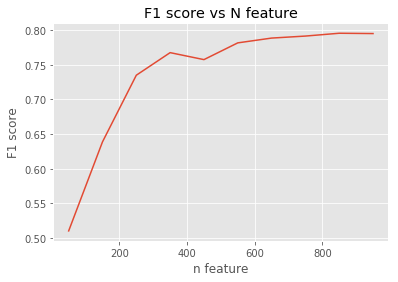

In [148]:
pd.Series(mlp_k_f1score).plot()
plt.title('F1 score vs N feature')
plt.ylabel('F1 score')
plt.xlabel('n feature')

In [130]:
mpl_param_grid= dict(clf__activation= ['tanh', 'relu', 'logistic'],
    clf__alpha=(0.0001, 0.001, 0.01, 0.05),
    clf__learning_rate= ['constant','adaptive'],
    clf__hidden_layer_sizes= [(50,50,50), (50,100,50), (100,)])

In [134]:
mlp_clf= Pipeline([('sel', SelectKBest(chi2, k= 800)),
                            ('clf', MLPClassifier(solver= 'lbfgs'))])

In [136]:
mlp_random_search= RandomizedSearchCV(mlp_clf, param_distributions= mpl_param_grid,
                                      scoring= 'f1', n_iter=10, n_jobs=-1, cv=3)

In [139]:
mlp_random_search.fit(X_vtrain, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('sel', SelectKBest(k=800, score_func=<function chi2 at 0x00000000092E9510>)), ('clf', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       lea...True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'clf__activation': ['tanh', 'relu', 'logistic'], 'clf__alpha': (0.0001, 0.001, 0.01, 0.05), 'clf__learning_rate': ['constant', 'adaptive'], 'clf__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [140]:
y_pred= mlp_random_search.predict(X_vtest)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [141]:
f1_score(y_test, y_pred)

0.7950169875424687

# Test Set

Predicion on the test set using Logistic Regression

In [142]:
# this code has been yoused to produced the clined pkl, to de-comment just if needed

'''
df_dev= pd.read_csv('task1.test.csv', usecols=[0,1], header= None)
df_dev.columns = ['text', 'id']
df_dev.set_index('id', inplace= True)
df_dev['text_clean']= df_dev['text'].apply(text_cleaner)
df_dev.to_pickle('cleaned_df.pkl')
'''


"\ndf_dev= pd.read_csv('task1.test.csv', usecols=[0,1], header= None)\ndf_dev.columns = ['text', 'id']\ndf_dev.set_index('id', inplace= True)\ndf_dev['text_clean']= df_dev['text'].apply(text_cleaner)\ndf_dev.to_pickle('cleaned_df.pkl')\n"

In [143]:
df_dev= pd.read_pickle('cleaned_df.pkl')
df_dev.set_index('id', inplace= True)

In [149]:
tvec= TfidfVectorizer(min_df=5, max_df= 0.9, lowercase= False, max_features= max_features, ngram_range= (1,3))
lr=  LogisticRegression(class_weight= 'balanced', solver= 'lbfgs', C= 1e3)

In [ ]:
lr_clf.fit(df['text_clean'], df['cat'])
y_pred= lr_clf.predict(df_dev['text_clean'])

In [ ]:
MAP_R= {1: 'propaganda', 0: 'non-propaganda'}

predictions= pd.Series(y_pred).map(MAP_R).values

with open("finale-predictions.txt", "w") as fout:
    for article_id, prediction in zip(df_dev.index, predictions):
        fout.write("%s\t%s\n" % (article_id, prediction))